In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [102]:
import winsound as sd
def beepsound():
    fr = 1000    # range : 37 ~ 32767
    du = 500     # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)

In [103]:
df =  pd.read_csv('ClusteringData.csv', header=0)

In [104]:
df = df.dropna()

In [105]:
#df = df.loc[df['임대건물명'] == '아파트'].dropna()
#다세대/연립
#단독/다가구
#아파트
#오피스텔

<AxesSubplot:>

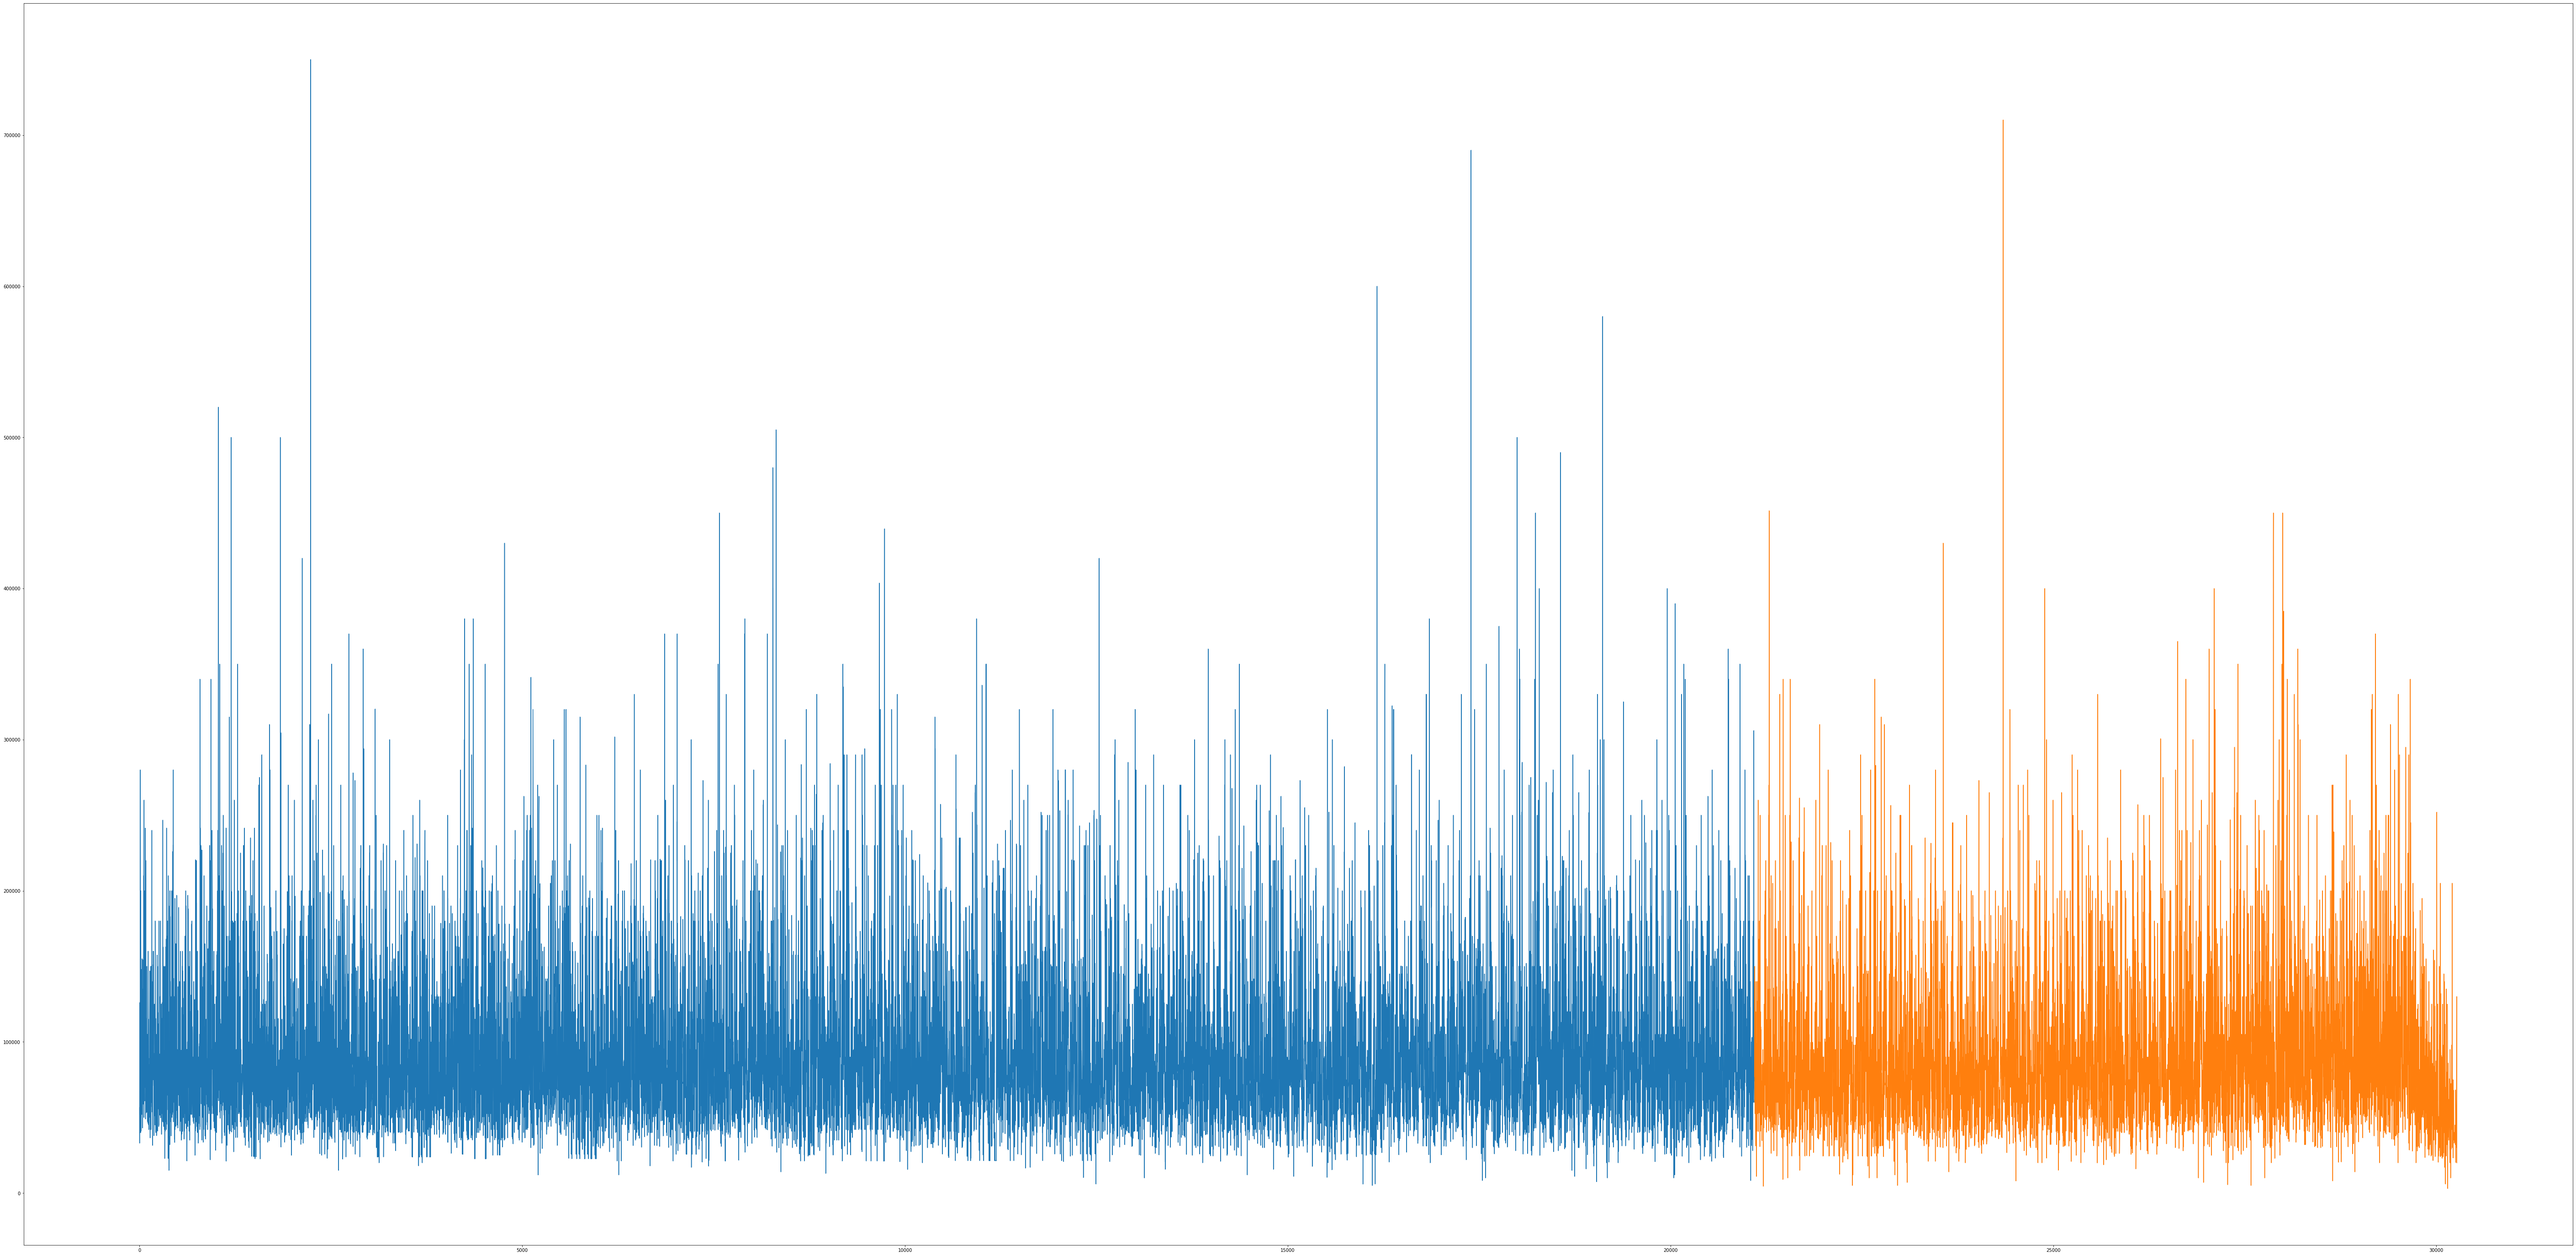

In [106]:
y_train = df['보증금'][:int(0.7*len(df))]
y_test = df['보증금'][int(0.7*len(df)):]
plt.figure(figsize=(100,50))
y_train.plot()
y_test.plot()

In [107]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 0


In [108]:
model = pm.auto_arima(y = y_train      
                      , d = 0         
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = True 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=467940.536, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=467099.410, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=467268.090, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=495511.438, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=466866.670, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=466743.161, Time=0.73 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=466743.741, Time=1.79 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=466841.375, Time=1.59 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=469892.217, Time=0.32 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 6.421 seconds


In [109]:
model.fit(y_train)

ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True)

In [110]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                19093
Model:               SARIMAX(3, 0, 0)   Log Likelihood             -233366.580
Date:                Wed, 01 Jun 2022   AIC                         466743.161
Time:                        15:04:20   BIC                         466782.446
Sample:                             0   HQIC                        466756.043
                              - 19093                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.917e+04    982.239     60.241      0.000    5.72e+04    6.11e+04
ar.L1          0.1759      0.006     30.224      0.000       0.165       0.187
ar.L2          0.0956      0.006     14.904      0.0

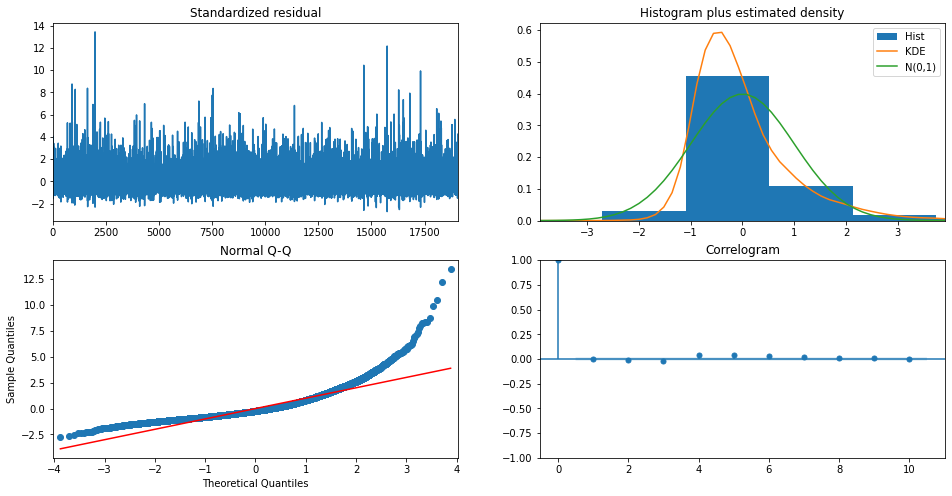

In [111]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

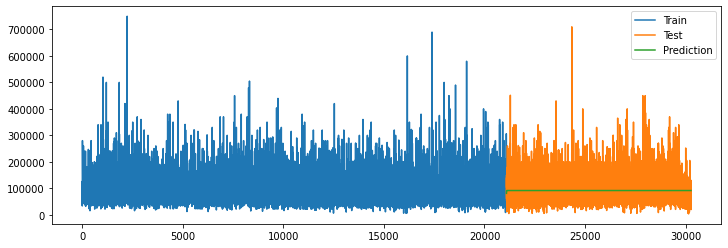

In [112]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [113]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [114]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

i=0

print(len(y_test))

for new_ob in y_test:
    
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

    if i%100==0:
        print(i)

    i = i+1

beepsound()

8184
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100


In [115]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
21097,105000,80715.553305
21098,77000,88480.289747
21100,150000,87743.598565
21101,60072,101416.434199
21102,140000,90308.188128
...,...,...
30260,50000,72492.634825
30261,30000,73596.136936
30266,67000,70843.910042
30269,130000,77782.564331


In [116]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                27277
Model:               SARIMAX(3, 0, 0)   Log Likelihood             -332997.499
Date:                Wed, 01 Jun 2022   AIC                         666004.997
Time:                        17:12:54   BIC                         666046.066
Sample:                             0   HQIC                        666018.235
                              - 27277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.917e+04    835.725     70.802      0.000    5.75e+04    6.08e+04
ar.L1          0.1778      0.005     36.331      0.000       0.168       0.187
ar.L2          0.0958      0.006     17.275      0.0

In [117]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=1080, width=1920, title_text="ARIMA(3,1,0)모형")
fig.show()

In [118]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

MAPE: 49.077


In [119]:
from sklearn import metrics

print("MAE : " + str(metrics.mean_absolute_error(y_test, y_pred)))
print("MSE : " + str(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : " + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print("R^2 : " + str(metrics.r2_score(y_test,y_pred)))

MAE : 33703.31990302475
MSE : 2185113280.02076
RMSE : 46745.19526133953
R^2 : 0.07693490063135033
